base_python env

In [1]:
from IPython import get_ipython
get_ipython().run_line_magic('reset', '-sf') 

import pandas as pd
import numpy as np
import glob
import re

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.stats import mannwhitneyu, ks_2samp, ks_1samp, norm
from statannot import add_stat_annotation
import os
from modules.data_loader import file_extraction, csv_to_xlsx, file_folder_creator
from modules.graphics_handler import histplot_fine_view, boxplot_fine_view


First of all, we need to choose export column in the input tables.
Here, we need Volume(unit) and SurfaceArea (um2). 

## Step 1. Grab .csv files, convert it to .xlsx and upload into dataframe (df).

In [2]:
search_path = 'data3/*cell*'
tot_vol_path = 'data3/total_vol_gfap_glt.xlsx'

In [3]:
csv_to_xlsx(search_path)

In [4]:
data = file_extraction(search_path)

In [5]:
data.head()

,volume,surface_area,animal_num,exp_group,slice_num,cell_num,protein
id,,,,,,,
1,0.016,0.584,1,ctrl,1,1,GFAP
2,0.013,0.398,1,ctrl,1,1,GFAP
3,0.003,0.146,1,ctrl,1,1,GFAP
4,0.003,0.146,1,ctrl,1,1,GFAP
5,0.123,2.215,1,ctrl,1,1,GFAP


We can see descriptive statistics for our data.

In [6]:
data.describe()

,volume,surface_area
count,25652.000000,25652.000000
mean,1.707995,8.746256
std,33.191584,136.327303
min,0.003000,0.146000
25%,0.003000,0.146000
50%,0.013000,0.419000
75%,0.071000,1.631500
max,2724.531000,11871.460000


In [7]:
CELL_PROTEIN = data['protein'].unique()[0]

In [8]:
data_cell = data[(data['protein']==CELL_PROTEIN)].copy(deep=True)

In [9]:
file_folder_creator('figs/GFAP')

'Folder created'

In [10]:
mask_ctrl_clust = data['exp_group']=='ctrl'
mask_SE_clust= data['exp_group']=='SE'

<AxesSubplot:>

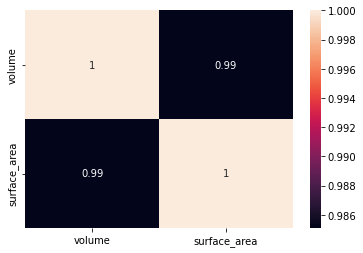

In [11]:
sns.heatmap(data[mask_ctrl_clust].loc[:, ['volume', 'surface_area']].corr(), annot=True)

<AxesSubplot:>

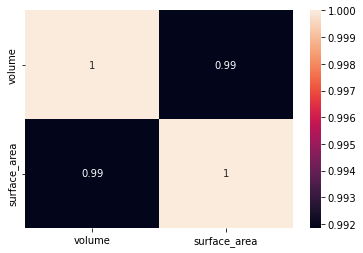

In [12]:
sns.heatmap(data[mask_SE_clust].loc[:, ['volume', 'surface_area']].corr(), annot=True)

We see a positive correlation between the cluster volume and its surface area for both group. This means that the larger the volume, the larger the surface area.

## GFAP calculation

Since GFAP does not aggregates in clusters, we consider using only the volume of the fraction (VF).

### GFAP volume fraction ctrl vs SE

In [13]:
wide_cell = pd.pivot_table(data_cell,
                        index = ['animal_num','slice_num','cell_num'],
                        columns = ['exp_group'],
                        values = ['volume'],
                        aggfunc = 'sum')
wide_cell = wide_cell.reindex(columns=[('volume','ctrl'),('volume','SE')])
wide_cell.head()

volume          
exp_group                         ctrl        SE
animal_num slice_num cell_num                   
1          1         1         426.392   388.022
                     2         126.508   262.875
                     3         127.725       NaN
           2         1             NaN   863.293
                     2             NaN  1065.542

In [14]:
tot_vol_df = pd.read_excel(f'{tot_vol_path}', usecols=[0,1], dtype='float64')
tot_vol_df.mean()

TotVol_glt_ctrl     9303.906648
TotVol_glt_SE      10018.908710
dtype: float64

In [15]:
wide_cell[('vf','ctrl')] = wide_cell.iloc[:,0]/tot_vol_df.mean()[0]
wide_cell[('vf','SE')] = wide_cell.iloc[:,1]/tot_vol_df.mean()[1]
wide_cell.head()

volume                  vf          
exp_group                         ctrl        SE      ctrl        SE
animal_num slice_num cell_num                                       
1          1         1         426.392   388.022  0.045829  0.038729
                     2         126.508   262.875  0.013597  0.026238
                     3         127.725       NaN  0.013728       NaN
           2         1             NaN   863.293       NaN  0.086166
                     2             NaN  1065.542       NaN  0.106353

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

('vf', 'ctrl') v.s. ('vf', 'SE'): Mann-Whitney-Wilcoxon test two-sided, P_val=1.424e-02 U_stat=1.180e+02


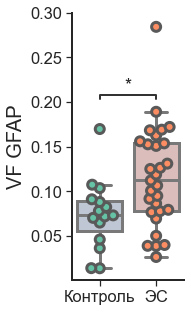

In [16]:
boxplot_fine_view(data=wide_cell.iloc[:,2:4], box_pairs=(('vf', 'ctrl'), ('vf', 'SE')), 
                        ylabel = f'VF {CELL_PROTEIN}', ylim = [0.0001, 0.3],
                        ytick = 0.05, figname= f'GFAP/VF {CELL_PROTEIN}')

In [17]:
percentile_vf_cell = wide_cell.iloc[:, 2:4].quantile([0.25, 0.50 , 0.75])
print(percentile_vf_cell)

                 vf          
exp_group      ctrl        SE
0.25       0.055297  0.077543
0.50       0.072875  0.111952
0.75       0.089358  0.153570


In [18]:
stat_vf_cell, p_vf_cell= mannwhitneyu(wide_cell.iloc[:, 2].dropna(), wide_cell.iloc[:, 3].dropna())
print('Statistics=%.3f, p=%.8f' % (stat_vf_cell, p_vf_cell))

Statistics=118.000, p=0.01423893


We see that after SE, GFAP volume fraction increase significantly after SE.

## Step 4. Save result 

Save obtain statistical criteria to excel file

In [19]:
stat_table_final = pd.DataFrame(data =[(p_vf_cell, stat_vf_cell)], 
                                index=['vf_cell'],
                                columns = ['p-value', 'MW(U)'])
stat_table_final

,p-value,MW(U)
vf_cell,0.014239,118.0


In [20]:
percentile_vf_cell

vf          
exp_group      ctrl        SE
0.25       0.055297  0.077543
0.50       0.072875  0.111952
0.75       0.089358  0.153570

In [21]:
with pd.ExcelWriter(f'output_table/final_out_{CELL_PROTEIN}.xlsx') as writer:  
    percentile_vf_cell.to_excel(writer, sheet_name='Percentiles', float_format="%.2f")
    stat_table_final.to_excel(writer, sheet_name='P-val, MW(U)', float_format="%.10f")